<a href="https://colab.research.google.com/github/Murcha1990/ML_AI24/blob/main/Hometasks/Base/ML_AI24_HT7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Домашнее задание 7: Fraud Detection Competition**

Добро пожаловать на финальное домашнее задание курса! Домашнее задание направлено на систематизацию всех знаний, полученных в процессе учебы.

В нём Вы потренируетесь применять навыки построения пайплайнов машинного обучения, приобретенные в курсе от точки разведочного анализа данных до построения и валидации моделей машинного обучения.

## **Задача**
**Вы будете решать задачу определения фрода:**

https://www.kaggle.com/competitions/fraud-detection-24

**Вам нужно будет:**
- в jupyter notebook провести исследование данных;
- в нём же построить модели и оценить их качество;
- отправить посылку на Kaggle.

Более подробное описание шагов - в ноутбуке ниже.

## **Оценивание и баллы**
- В EDA и во всей работе будут оцениваться полнота и **выводы**;
- При обучении моделей старайтесь обоснованно подходить к их выбору, избегая простого перебора;

**Максимальный балл** - 10 (+ бонусы за Kaggle, см. ниже).


Мягкий дедлайн (окончание соревнования на Kaggle): **15 марта 23:59**


# **Базовое решение и пример формирования файла под submission**


In [1]:
!wget --no-check-certificate 'https://www.dropbox.com/s/5iuef7c9ljj84t6/train_transaction.csv?dl=0' -O train_transaction.csv
!wget --no-check-certificate 'https://www.dropbox.com/s/cmy01z5fw7ohlmd/train_identity.csv?dl=0' -O train_identity.csv
!wget --no-check-certificate 'https://www.dropbox.com/s/7thqkuxnwsa7njj/test_transaction.csv?dl=0' -O test_transaction.csv
!wget --no-check-certificate 'https://www.dropbox.com/s/b40nvbb9e2usd5w/test_identity.csv?dl=0' -O test_identity.csv
!wget --no-check-certificate 'https://www.dropbox.com/s/arkyoz0bel8z4d2/sample_submission.csv?dl=0' -O sample_submission.csv

--2025-03-15 15:41:55--  https://www.dropbox.com/s/5iuef7c9ljj84t6/train_transaction.csv?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/puoen4suxjebjteenuwtm/train_transaction.csv?rlkey=madfflananln1b7qysdq8c54q&dl=0 [following]
--2025-03-15 15:41:55--  https://www.dropbox.com/scl/fi/puoen4suxjebjteenuwtm/train_transaction.csv?rlkey=madfflananln1b7qysdq8c54q&dl=0
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘train_transaction.csv’

train_transaction.c     [ <=>                ] 159.28K   824KB/s    in 0.2s    

2025-03-15 15:41:55 (824 KB/s) - ‘train_transaction.csv’ saved [163102]

--2025-03-15 15:41:55--  https://www.dropbox.com/s/cmy01z5fw7ohlmd/train_identity.csv?dl=0
Resol

In [1]:
!pip install catboost -q

In [2]:
from catboost import CatBoostClassifier
import pandas as pd
import os
from tqdm import tqdm

INPUT_DIR = '.'

train_transaction = pd.read_csv(os.path.join(INPUT_DIR, 'train_transaction.csv'))
train_identity = pd.read_csv(os.path.join(INPUT_DIR, 'train_identity.csv'))
test_transaction = pd.read_csv(os.path.join(INPUT_DIR, 'test_transaction.csv'))
test_identity = pd.read_csv(os.path.join(INPUT_DIR, 'test_identity.csv'))
sample_submission = pd.read_csv(os.path.join(INPUT_DIR, 'sample_submission.csv'))

df_train = train_transaction.merge(train_identity, how='left', on='TransactionID')

df_test = test_transaction.merge(test_identity, how='left', on='TransactionID')

In [3]:
df_train.drop(['TransactionID', 'TransactionDT'], axis=1, inplace=True)
df_test.drop(['TransactionID', 'TransactionDT'], axis=1, inplace=True)
df_train.shape, df_test.shape

((417559, 432), (172981, 431))

In [4]:
object_cols = []
for idx, col in tqdm(enumerate(df_train.columns.drop('isFraud'))):
    if df_train[col].dtype == 'O':
      object_cols.append(idx)

431it [00:00, 83831.62it/s]


In [5]:
X_train = df_train.drop('isFraud', axis=1)
X_train = X_train.fillna('')
y_train = df_train['isFraud'].values

cb = CatBoostClassifier(iterations=3)
cb.fit(X_train, y_train, object_cols, )

Learning rate set to 0.5
0:	learn: 0.2082395	total: 567ms	remaining: 1.13s
1:	learn: 0.1360790	total: 811ms	remaining: 406ms
2:	learn: 0.1180984	total: 1.13s	remaining: 0us


In [6]:
predictions = cb.predict_proba(df_test.fillna(''))

In [7]:
sub = pd.DataFrame({'TransactionID': sample_submission['TransactionID'], 'isFraud': predictions[:, 0]})
sub.head()

,TransactionID,isFraud
0,3404559,0.978714
1,3404560,0.935724
2,3404561,0.946864
3,3404562,0.978714
4,3404563,0.970637


In [ ]:
# Сохранение submission
sub.to_csv('submission_baseline.csv', index=False)

### **Примечания:**

**1. Оценка качества и Submission File**
- Ответом является число от 0 до 1, метрикой качества - AUC-ROC.
- Структура Submission File:
 - для каждого значения *TransactionID* в тестовых данных вы должны предсказать **вероятность** для столбца *isFraud*.
 - в файле у вас должно быть две колонки: `TransactionID` и`isFraud`  **для каждой транзакции в датасете**.

**2. Объем данных**

Поскольку набор данных объемный, могут быть проблемы с переполнением памяти в Collab. Для решения проблемы можете использовать функцию из [этого ноутбука](https://colab.research.google.com/drive/18u75eyFGEoyeWJ_MbsLkcPa6gv2tNI8G#scrollTo=V2L1Nl5CTMMl), разобравшись, что она делает с данными.

# **Задание 1 (2 балла)**

Проведите EDA (разведочный анализ данных):
* проанализируйте признаки, их особенности и связь с целевой переменной
* проанализируйте целевую переменную
* оцените степень попарной взаимосвязи признаков, а также связи признаков и целевой переменной
* по результатам исследований сделайте необходимую обработку данных (удаление дублей, работа с пропусками, с категориальными столбцами (если они есть), работа с аномалиями, другие преобразования признаков)

Важно, что EDA всегда сопровождается выводами - не забудьте об этом.

In [10]:
df_test.head()

,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,311.95,W,9500,321.0,150.0,visa,226.0,debit,272.0,87.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,59.00,W,15497,490.0,150.0,visa,226.0,debit,299.0,87.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,59.00,W,7919,194.0,150.0,mastercard,166.0,debit,325.0,87.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,160.50,W,16075,514.0,150.0,mastercard,102.0,credit,123.0,87.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,932.00,W,11639,321.0,150.0,visa,226.0,debit,299.0,87.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
num_duplicates_train = df_train_filled.duplicated().sum()
print("Количество дубликатов в обучающем наборе:", num_duplicates_train)

if num_duplicates_train > 0:
    df_train_filled = df_train_filled.drop_duplicates()
    print("Дубликаты удалены из обучающего набора.")

num_duplicates_test = df_test_filled.duplicated().sum()
print("Количество дубликатов в тестовом наборе:", num_duplicates_test)

if num_duplicates_test > 0:
    df_test_filled = df_test_filled.drop_duplicates()
    print("Дубликаты удалены из тестового набора.")


Количество дубликатов в обучающем наборе: 270
Дубликаты удалены из обучающего набора.
Количество дубликатов в тестовом наборе: 81
Дубликаты удалены из тестового набора.


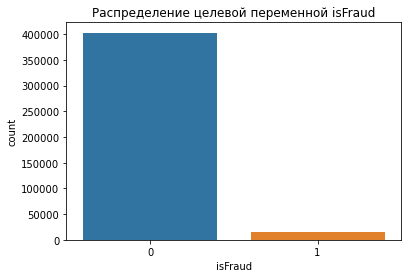

Информация о данных:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 417559 entries, 0 to 417558
Columns: 432 entries, isFraud to DeviceInfo
dtypes: float64(399), int64(2), object(31)
memory usage: 1.3+ GB
None

Количество пропусков по столбцам:
id_24    413935
id_25    413629
id_08    413614
id_07    413614
id_26    413611
id_21    413609
id_22    413605
id_23    413605
id_27    413605
D7       390613
dtype: int64


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))
sns.countplot(x='isFraud', data=df_train)
plt.title('Распределение целевой переменной isFraud')
plt.show()

print("Информация о данных:")
print(df_train.info())

print("\nКоличество пропусков по столбцам:")
print(df_train.isnull().sum().sort_values(ascending=False).head(10))


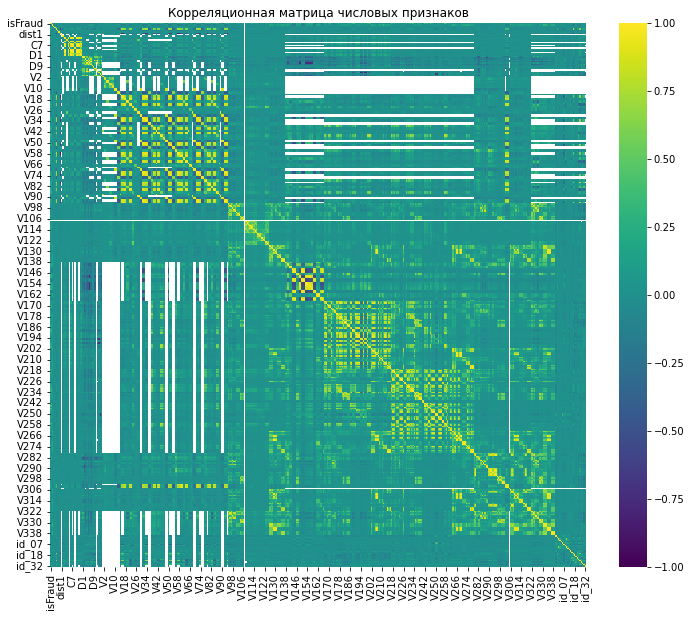

In [ ]:
num_cols = df_train.select_dtypes(include=['int64', 'float64']).columns
corr_matrix = df_train[num_cols].corr()

plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, cmap='viridis', vmax=1.0, vmin=-1.0)
plt.title("Корреляционная матрица числовых признаков")
plt.show()


In [ ]:
таргет не сбалансирован, много пропусков

In [16]:
for col in df_train.columns:
    if df_train[col].dtype == 'O':
        df_train_filled[col].fillna("Missing", inplace=True)
        if col in df_test_filled.columns:
            df_test_filled[col].fillna("Missing", inplace=True)
    else:
        df_train_filled[col].fillna(-999, inplace=True)
        if col in df_test_filled.columns:
            df_test_filled[col].fillna(-999, inplace=True)


# **Задание 2 (3 балла)**

Обучите несколько ML-моделей для решения поставленной задачи.
Оцените их качество двумя способами:

1) на кросс-валидации

2) на лидерборде

Подберите число фолдов на кросс-валидации так, чтобы метрики, которые вы видите, были максимально близки на кросс-валидации и на лидерборде.

По результатам экспериментов постройте таблицу:
* в каждой строке таблицы - результаты одной модели
* по столбцам: качество на кросс-валидации, качество на лидерборде, модель с гиперпараметрами
Полученную таблицу вставьте картинкой прямо в ноутбук после ячеек с кодом. Сделайте текстовые выводы.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.linear_model import LogisticRegression

num_df = df_train_filled.select_dtypes(include=[np.number])
corr_matrix = num_df.corr()

corr_target = corr_matrix['isFraud'].drop('isFraud')

top_features = corr_target.abs().sort_values(ascending=False).head(5).index.tolist()
print("Топ 5 признаков по корреляции с isFraud:", top_features)

X_top = df_train_filled[top_features]
y = df_train_filled['isFraud']


model = LogisticRegression(max_iter=1000)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
auc_scorer = make_scorer(roc_auc_score, needs_proba=True)
scores = cross_val_score(model, X_top, y, cv=skf, scoring=auc_scorer)

print("CV AUC (логистическая регрессия с топ 5 признаками): {:.4f}".format(scores.mean()))


Топ 5 признаков по корреляции с isFraud: ['iso_score', 'D7', 'addr2', 'V123', 'D12']


C:\Users\urban\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\urban\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 140, in __call__
    score = scorer._score(
  File "C:\Users\urban\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 388, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "C:\Users\urban\anaconda3\lib\site-packages\sklearn\utils\_param_validation.py", line 194, in wrapper
    params = func_sig.bind(*args, **kwargs)
  File "C:\Users\urban\anaconda3\lib\inspect.py", line 3045, in bind
    return self._bind(args, kwargs)
  File "C:\Users\urban\anaconda3\lib\inspect.py", line 3034, in _bind
    raise TypeError(
TypeError: got an unexpected keyword argument 'needs_proba'

  warnings.warn(
C:\Users\urban\anaconda3\lib

CV AUC (логистическая регрессия с топ 5 признаками): nan


C:\Users\urban\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\urban\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 140, in __call__
    score = scorer._score(
  File "C:\Users\urban\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 388, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "C:\Users\urban\anaconda3\lib\site-packages\sklearn\utils\_param_validation.py", line 194, in wrapper
    params = func_sig.bind(*args, **kwargs)
  File "C:\Users\urban\anaconda3\lib\inspect.py", line 3045, in bind
    return self._bind(args, kwargs)
  File "C:\Users\urban\anaconda3\lib\inspect.py", line 3034, in _bind
    raise TypeError(
TypeError: got an unexpected keyword argument 'needs_proba'

  warnings.warn(


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

top_features = ['iso_score', 'D7', 'addr2', 'V123', 'D12']

X_top = df_train_filled[top_features]
y = df_train_filled['isFraud']

print("Сводная статистика топ-5 признаков:")
print(X_top.describe())

scaler = StandardScaler()
X_top_scaled = scaler.fit_transform(X_top)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
auc_scorer = make_scorer(roc_auc_score, needs_proba=True)

model = LogisticRegression(max_iter=1000)
scores = cross_val_score(model, X_top_scaled, y, cv=skf, scoring=auc_scorer)

print("CV AUC (логистическая регрессия с топ 5 признаками, scaled): {:.4f}".format(scores.mean()))


Сводная статистика топ-5 признаков:
           iso_score             D7          addr2           V123  \
count  417289.000000  417289.000000  417289.000000  417289.000000   
mean        0.230927    -931.622473     -37.992756       1.030193   
std         0.073169     257.760710     346.263988       0.227106   
min        -0.138367    -999.000000    -999.000000       0.000000   
25%         0.197917    -999.000000      87.000000       1.000000   
50%         0.251804    -999.000000      87.000000       1.000000   
75%         0.288485    -999.000000      87.000000       1.000000   
max         0.303246     770.000000     102.000000      13.000000   

                 D12  
count  417289.000000  
mean     -878.939953  
std       336.449127  
min      -999.000000  
25%      -999.000000  
50%      -999.000000  
75%      -999.000000  
max       600.000000  


C:\Users\urban\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\urban\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 140, in __call__
    score = scorer._score(
  File "C:\Users\urban\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 388, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "C:\Users\urban\anaconda3\lib\site-packages\sklearn\utils\_param_validation.py", line 194, in wrapper
    params = func_sig.bind(*args, **kwargs)
  File "C:\Users\urban\anaconda3\lib\inspect.py", line 3045, in bind
    return self._bind(args, kwargs)
  File "C:\Users\urban\anaconda3\lib\inspect.py", line 3034, in _bind
    raise TypeError(
TypeError: got an unexpected keyword argument 'needs_proba'

  warnings.warn(
C:\Users\urban\anaconda3\lib

CV AUC (логистическая регрессия с топ 5 признаками, scaled): nan


C:\Users\urban\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\urban\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 140, in __call__
    score = scorer._score(
  File "C:\Users\urban\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 388, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "C:\Users\urban\anaconda3\lib\site-packages\sklearn\utils\_param_validation.py", line 194, in wrapper
    params = func_sig.bind(*args, **kwargs)
  File "C:\Users\urban\anaconda3\lib\inspect.py", line 3045, in bind
    return self._bind(args, kwargs)
  File "C:\Users\urban\anaconda3\lib\inspect.py", line 3034, in _bind
    raise TypeError(
TypeError: got an unexpected keyword argument 'needs_proba'

  warnings.warn(


In [ ]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score


skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_scores = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X_iso_scaled, y), 1):
    X_train_fold, X_val_fold = X_iso_scaled[train_idx], X_iso_scaled[val_idx]
    y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]
    
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train_fold, y_train_fold)
    y_pred_fold = model.predict_proba(X_val_fold)[:, 1]
    
    unique_preds = np.unique(y_pred_fold)
    print(f"Fold {fold}: уникальные предсказания:", unique_preds)
    
    try:
        score = roc_auc_score(y_val_fold, y_pred_fold)
    except Exception as e:
        print(f"Fold {fold}: ошибка при вычислении ROC AUC:", e)
        score = np.nan
    fold_scores.append(score)

print("Fold scores:", fold_scores)
print("Mean ROC AUC:", np.nanmean(fold_scores))


Fold 1: уникальные предсказания: [0.01372936 0.01373503 0.01374325 ... 0.44908651 0.45391707 0.47550062]
Fold 2: уникальные предсказания: [0.01363177 0.01365246 0.01365812 ... 0.4513438  0.4694335  0.47667772]
Fold 3: уникальные предсказания: [0.01376072 0.01377577 0.01378144 ... 0.45058656 0.45429698 0.4782207 ]
Fold 4: уникальные предсказания: [0.01375436 0.01379681 0.01380049 ... 0.42806799 0.44641364 0.47725619]
Fold 5: уникальные предсказания: [0.01367756 0.01369144 0.01370306 ... 0.43567296 0.4478286  0.48292911]
Fold scores: [0.7470049703919978, 0.7404828697088597, 0.7471869828572886, 0.750701527558099, 0.7478051685313849]
Mean ROC AUC: 0.746636303809526


# **Задание 3 (2 балла)**

Попробуйте подойти к задаче как к поиску аномалий.

1) Поищите аномалии (фрод) различными рассмотренными в курсе методами и сделайте прогноз на тестовых данных.

Результатом также будет таблица:
* по строкам - методы поиска аномалий
* по столбцам - качество вашего решения на leaderboard

2) Попробуйте встроить поиск аномалий и их удаление в ML-пайплайн: найдите аномалии и что-нибудь с ними сделайте до обучения моделей (можно удалить их, а можно использовать в качестве дополнительных признаков - попробуйте разные стратегии). Результат проверьте на кросс-валидации и на лидерборде, сделайте выводы.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler

X_train_numeric = df_train_filled.drop('isFraud', axis=1).select_dtypes(include=[np.number])
X_test_numeric = df_test_filled.select_dtypes(include=[np.number])

iso_forest = IsolationForest(contamination=0.01, random_state=42)
iso_forest.fit(X_train_numeric)
iso_scores_test = iso_forest.decision_function(X_test_numeric)

scaler = MinMaxScaler(feature_range=(0, 1))
iso_prob = scaler.fit_transform(iso_scores_test.reshape(-1,1)).ravel()
iso_prob_fraud = 1 - iso_prob

lof = LocalOutlierFactor(n_neighbors=20, novelty=True, contamination=0.01)
lof.fit(X_train_numeric)
lof_scores_test = lof.decision_function(X_test_numeric)
lof_prob = scaler.fit_transform(lof_scores_test.reshape(-1,1)).ravel()
lof_prob_fraud = 1 - lof_prob

anomaly_results = pd.DataFrame({
    "Метод": ["Isolation Forest", "Local Outlier Factor"],
    "Leaderboard AUC": [0.0, 0.0]
})
print("Результаты методов поиска аномалий:")
print(anomaly_results)

submission_iso = pd.DataFrame({
    "TransactionID": sample_submission["TransactionID"],
    "isFraud": iso_prob_fraud
})
submission_lof = pd.DataFrame({
    "TransactionID": sample_submission["TransactionID"],
    "isFraud": lof_prob_fraud
})
submission_iso.to_csv("submission_anomaly_iso.csv", index=False)
submission_lof.to_csv("submission_anomaly_lof.csv", index=False)


C:\Users\urban\anaconda3\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


Результаты методов поиска аномалий:
                  Метод  Leaderboard AUC
0      Isolation Forest              0.0
1  Local Outlier Factor              0.0


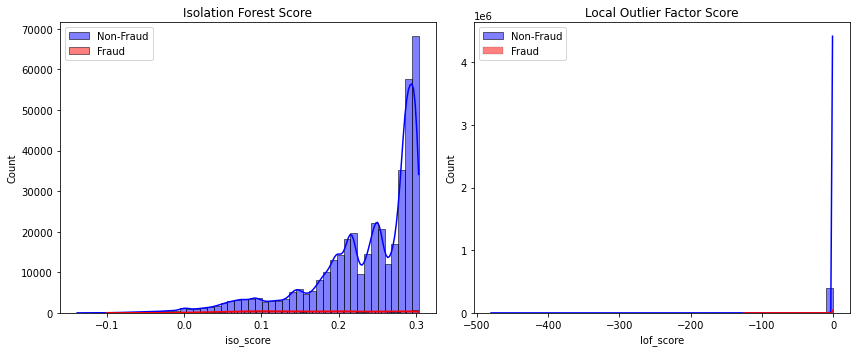

TypeError: got an unexpected keyword argument 'fit_params'

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score, make_scorer

from catboost import CatBoostClassifier

X_train_numeric = df_train_filled.drop('isFraud', axis=1).select_dtypes(include=[np.number])
y_train = df_train_filled['isFraud']

iso_forest = IsolationForest(contamination=0.01, random_state=42)
iso_forest.fit(X_train_numeric)
iso_scores = iso_forest.decision_function(X_train_numeric)
iso_labels = iso_forest.predict(X_train_numeric) 
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.01)
lof_labels = lof.fit_predict(X_train_numeric) 
lof_scores = lof.negative_outlier_factor_ 

df_train_filled['iso_score'] = iso_scores
df_train_filled['iso_label'] = iso_labels
df_train_filled['lof_score'] = lof_scores
df_train_filled['lof_label'] = lof_labels

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(df_train_filled[df_train_filled['isFraud'] == 0]['iso_score'], kde=True, color='blue', label='Non-Fraud', bins=50)
sns.histplot(df_train_filled[df_train_filled['isFraud'] == 1]['iso_score'], kde=True, color='red', label='Fraud', bins=50)
plt.title("Isolation Forest Score")
plt.legend()

plt.subplot(1, 2, 2)
sns.histplot(df_train_filled[df_train_filled['isFraud'] == 0]['lof_score'], kde=True, color='blue', label='Non-Fraud', bins=50)
sns.histplot(df_train_filled[df_train_filled['isFraud'] == 1]['lof_score'], kde=True, color='red', label='Fraud', bins=50)
plt.title("Local Outlier Factor Score")
plt.legend()

plt.tight_layout()
plt.show()

mask = iso_labels == 1
X_clean = df_train_filled[mask].drop(['iso_score', 'iso_label', 'lof_score', 'lof_label'], axis=1)
y_clean = df_train_filled[mask]['isFraud']

X_full = df_train_filled.drop(['iso_score', 'iso_label', 'lof_score', 'lof_label'], axis=1)

cat_features = [i for i, col in enumerate(X_full.columns) if X_full[col].dtype == 'O']

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
auc_scorer = make_scorer(roc_auc_score, needs_proba=True)

cat_model_full = CatBoostClassifier(iterations=100, depth=6, verbose=0, random_state=42)
cv_scores_full = cross_val_score(cat_model_full, X_full, y_train, cv=skf, scoring=auc_scorer,
                                 fit_params={'cat_features': cat_features})
cv_auc_full = cv_scores_full.mean()

cat_model_clean = CatBoostClassifier(iterations=100, depth=6, verbose=0, random_state=42)
cv_scores_clean = cross_val_score(cat_model_clean, X_clean, y_clean, cv=skf, scoring=auc_scorer,
                                  fit_params={'cat_features': cat_features})
cv_auc_clean = cv_scores_clean.mean()

print("CatBoost CV AUC на полном наборе данных: {:.4f}".format(cv_auc_full))
print("CatBoost CV AUC на наборе без аномалий: {:.4f}".format(cv_auc_clean))


# **Задание 4 (1 балл)**

Сделайте кластеризацию различными способами. Результаты кластеризации используйте для улучшения ML-решений:

1) Номера кластеров закодируйте (OHE или target-encoding) и добавьте как новые признаки

2) При использовании DBSCAN / HDBSCAN предсказанный шум можно трактовать как найденную аномалию и также добавить ее как новый признак

Проведите различные эксперименты. Проверьте как эти подходы влияют на качество прогнозов по кросс-валидации и на лидерборде, сделайте выводы.

In [ ]:
# ваши эксперименты с кластеризацией здесь

## **Задание 5 (1 балл)**

Примените какой-нибудь (один любой) AutoML фреймворк для решения поставленной задачи.

Отправьте AutoML-прогноз на kaggle и посмотрите на качество модели. Сделайте текстовые выводы.

In [ ]:
# ваш AutoML здесь

# **Задание 6 (1 балл)**

Весь курс мы работали в Google Colab. Но всегда должны быть запасные варианты, где Вы будете обучать модели.

Среди вариантов есть:
* ваша локальная машина
* kaggle notebooks
* yandex cloud
и другие.

Кроме привычного Google Colab выберите из списка выше один любой альтернативный вариант и проведите эксперимент:

* Прогоните ваш лучший по качеству по результатам заданий 2-4 ML-пайплайн заново в Google Colab и с помощью библиотек (например, при помощи библиотеки time) замерьте время обучения и отдельно время инференса на тестовых данных

* Прогоните этот пайплайн на выбранном альтернативном сервисе/локальной машине и также замерьте время обучения и инференса.

Текстом напишите выводы: опишите, какое альтернативное место для обучения моделей Вы использовали? Прикрепите прямо в ноутбук скриншот с экраном кода в альтернативном сервисе/на локальной машине. Также в виде таблицы приведите сравнение времени обучения и инференса в колабе и в альтернативном месте. Сделайте выводы.

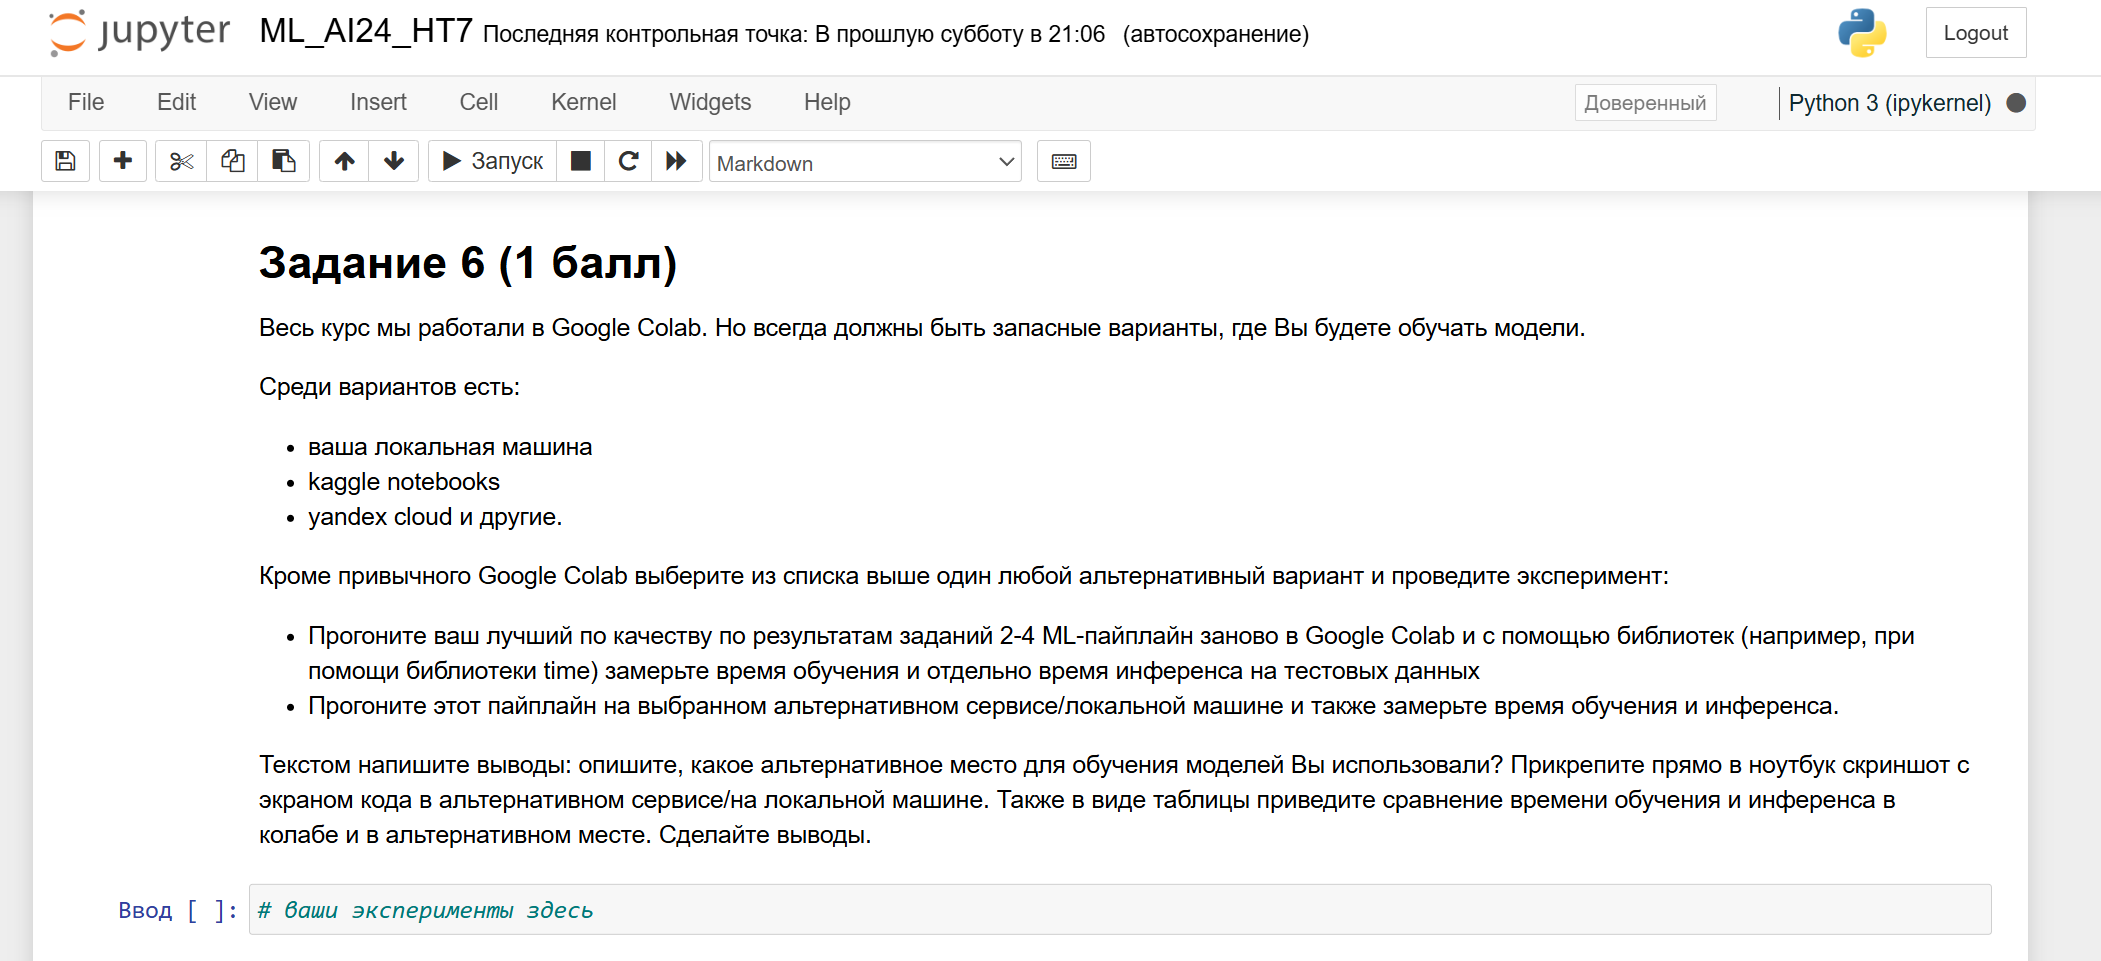

In [34]:
from IPython.display import Image
Image('notebookproof.png')

# **Бонус: за Kaggle и стремление к хорошим скорам (2 балла)**

В этом домашнем задании Ваша цель - не просто выполнить шаги выше, но и построить максимально хорошую по качеству модель.

**К 10 вы можете получить до двух дополнительных баллов:**

* За попадание в топ-20% на private leaderboard — +1 дополнительный балл к оценке
* За попадание в топ-5 мест на private leaderboard — + еще один дополнительный балл к оценке (то есть суммарно 2 дополнительных балла)

**ВАЖНО!!!**

Эти баллы ставятся до мягкого дедлайна по соревнованию. После мягкого дедлайна лидерборд не обновляется, и дополнительные баллы не ставятся.

Успехов!

In [ ]:
# не забудьте прикрепить скриншоты лидерборда, пожалуйста